<h1 align="center">Image Classification and Computer Vision</h1>

## Overview

This notebook demonstrates image classification on two datasets - one small and simple and the other large and complex - using different types of features and different models.

The models demonstrated are:

+ Logistic regression using Haralick (texture-based) features

+ Logistic regression using histograms as features

+ Logistic regression using linear binary patterns (LBP) as features

+ Logistic regression using SURF (Speeded Up Robust Features) with a *visual bag-of-words* approach

In [1]:
%matplotlib inline 

import mahotas as mh

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, LeaveOneOut, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import numpy as np

from scipy.spatial import distance, distance_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt

<br/>

## I. Classification on a small dataset

First, we try classification on a small dataset consisting of just 90 images and 3 classes:
+ buildings
+ outdoor scenery
+ sheets with printed text

All images are high resolution (5MP) color JPEG images with file sizes between 1 and 3 MB.

### Feature selection - pixels as features
The most obvious feature are pixel colors. Every image can be treated as a W x H length vector of RGB colors.

But raw pixels as features have a number of problems:
+ there is rarely any direct relation between the color and position of pixel and an object.
+ model won't be robust against even small changes in positions, angles or illuminations of objects.

Additionally, since number of images is very small while number of features is very large, this is an extreme example of the $p >> n$ problem with P as large as 5 million while N is just 90. (TODO As I understand it, this means it's an _underdetermined system_ and there are either no solutions or infinitely many solutions all of which satisfy the equations and yield zero training error but generalize very badly).

So pixels as features is not a good idea. 


### Feature selection - textures as features
Instead of pixels, we can use _textures_ as features on datasets where textures are sufficiently discrimative. 

In this dataset, since buildings, sceneries and printed text have very different and unique textures, they are a good candidate for classification features.

We use texture based Haralick features - also known as Grey Level Co-occurrence Matrix (GLCM). The idea behind [co-occurrence matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix) is that if there are n grey levels in an image, we create an nxn matrix. Each element tells us how many times $i^{th}$ level and $j^{th}$ levels occur in a relative position specified by a position/offset operator. 

Since GLCM is not available from OpenCV 3.x and was already in legacy module in OpenCV 2.x, we avoid OpenCV and instead use the _Mahotas_ library for this task.



---
<div class="alert alert-warning">
<h3>A short note on image loading and display</h3>
<br/>
numpy arrays representing image data can be displayed using matplotlib's `imshow()` function as follows:
</div>


In [3]:
img = mh.imread('BuildingMachineLearningSystemsWithPython/SimpleImageDataset/scene12.jpg', as_grey=False)

img_gray = mh.imread('BuildingMachineLearningSystemsWithPython/SimpleImageDataset/scene12.jpg', as_grey=True)
img_gray = img_gray.astype(np.uint8)

In [4]:
img.shape, img.dtype, img_gray.shape, img_gray.dtype, np.min(img_gray), np.max(img_gray)

((1944, 2592, 3), dtype('uint8'), (1944, 2592), dtype('uint8'), 0, 255)

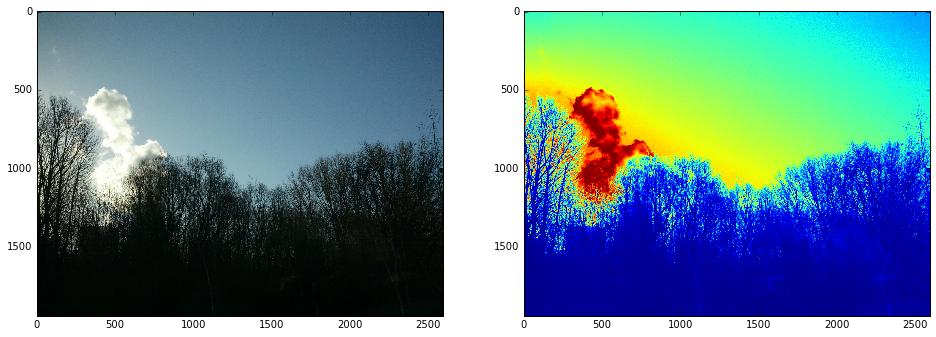

In [5]:
plt.figure(figsize=(16,12))
plt.subplot(1,2,1)
plt.imshow(img)

plt.subplot(1,2,2)
plt.imshow(img_gray)

plt.show()

Notice that matplotlib plots grayscale images using some synthesized hue. To prevent this, set `plt.gray()` or preferably set the `cmap` argument.

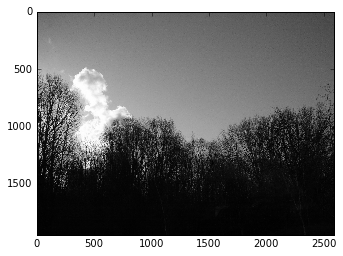

In [6]:
# plt.gray() # This works, but also seems to permanently set matplotlib default colormap for duration of session.
plt.imshow(img_gray, cmap=plt.cm.gray)
plt.show()

---

### More on Haralick features

Haralick features are obtained using Mahotas like this:

In [7]:
haralick_features = mh.features.haralick(img_gray)

In [8]:
haralick_features.shape, haralick_features.dtype

((4, 13), dtype('float64'))

The features are 4 x 13 sized. 

The 4 refers to the 4 directions of co-occurrence - vertical, horizontal, diagonal, and anti-diagonal. 

The 13 refers to the 13 descriptive statistics derived from the co-occurrence matrix in order to describe the texture of the image, as described [here](http://murphylab.web.cmu.edu/publications/boland/boland_node26.html).

It is these 4 x 13 = 52 variables that are used as features for image classification. Note that since the 13 stats are all derived from the same co-occurrence matrix, they are not really *independent variables*, but we ignore this for classification.

In [9]:
haralick_features.ravel().shape

(52,)

### Building the dataset

In [10]:
from glob import glob
import os

images = glob('BuildingMachineLearningSystemsWithPython/SimpleImageDataset/*')

dataset = np.empty((0,52), dtype=np.float64)

labels = []

for idx, i in enumerate(images):
    print('Image {0}:{1}'.format(idx, i))
    temp_img = mh.imread(i, as_grey=True).astype(np.uint8)
    har_features = mh.features.haralick(temp_img).reshape((1,52))
    dataset = np.concatenate((dataset, har_features), axis=0)
    
    labels.append(os.path.basename(i)[:-len('00.jpg')])
    
dataset.shape, dataset

Image 0:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/text07.jpg
Image 1:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/text01.jpg
Image 2:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/building05.jpg
Image 3:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/building22.jpg
Image 4:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/scene12.jpg
Image 5:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/scene13.jpg
Image 6:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/scene18.jpg
Image 7:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/scene07.jpg
Image 8:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/text11.jpg
Image 9:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/text06.jpg
Image 10:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/scene04.jpg
Image 11:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/building00.jpg
Image 12:BuildingMachineLearningS

((90, 52), array([[  5.09945866e-03,   2.21952451e+01,   9.75731773e-01, ...,
           3.34139027e+00,  -3.15797728e-01,   9.86343491e-01],
        [  8.18186979e-04,   6.66993679e+01,   9.83565372e-01, ...,
           4.02996516e+00,  -3.25660332e-01,   9.95085826e-01],
        [  1.18108477e-03,   2.93837458e+01,   9.96459815e-01, ...,
           3.57944534e+00,  -4.31785242e-01,   9.99153264e-01],
        ..., 
        [  6.51198152e-04,   1.30703508e+02,   9.87109018e-01, ...,
           4.52316353e+00,  -3.38993188e-01,   9.96978175e-01],
        [  3.00887752e-03,   2.87232188e+02,   9.72457263e-01, ...,
           4.89659718e+00,  -2.82836774e-01,   9.93032988e-01],
        [  2.70103008e-03,   2.02258373e+01,   9.96108662e-01, ...,
           3.45222061e+00,  -3.84123512e-01,   9.96679923e-01]]))

In [11]:
np.unique(labels, return_counts=True)

(array(['building', 'scene', 'text'], 
       dtype='<U8'), array([30, 30, 30]))

### Classification using Logistic Regression on Haralick features

Since each of the Haralick features has different scales, we use a StandardScaler preprocessor.

Since there are very few observations in the dataset, we use simple leave-one-out cross validation.

In [12]:
classifier = Pipeline([  ('scaler', StandardScaler()),
                         ('classifier', LogisticRegression())  ])
cv = LeaveOneOut(len(images))
scores = cross_val_score(classifier, dataset, labels, cv=cv)
print(scores)
print('Mean accuracy using Haralick features:', np.mean(scores))

[ 1.  1.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.
  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.
  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.  0.  1.  0.  1.  1.  1.  1.  1.
  1.  0.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.]
Mean accuracy using Haralick features: 0.811111111111


A score of 1 means predicted class is same as actual class; 0 means predicted class is different from actual class.

In [13]:
len(scores[scores == 0]), len(scores[scores == 1]), len(scores[scores == 1])/len(images)

(17, 73, 0.8111111111111111)

### Feature selection - color histograms

The book also demonstrates classification using another set of features - the color histograms. 

A histogram tells us the number of pixels of a particular color. But 24-bit RGB images can have 256x256x256=16.7 _million_ possible color combinations which is just too many. 

To reduce the size of the colorspace, the book reduces images to 4x4x4 = 64 colors. It just divides the R,G,and B arrays by 64 for this. So effectively, a pixel with R=57 now becomes R=0, one with R=90 now becomes R=1, etc.

The book then calculates a single level for each pixel as follows: `level = 1*R + 4*B + 16*G`.

I didn't understand why it combines it this way. 

It then calculates the histogram with these 64 level values as bins. 

It finally uses the _log_ of the frequencies as features. They says it makes for *"better features"* but don't explain why.

In [21]:
def chist(rgb_image):
    reduced_img = rgb_image // 64
    
    # reduced_img is of shape (h, w, 3). What transpose does is modify the view so that the channels (ie, last axis)
    # now becomes the primary axis, while height and width become the second and third axes. The only purpose 
    # of doing this is to assign the 3 channels to 3 variables. 
    # This could also have been done simply by using slice notation.
    r,g,b = reduced_img.transpose((2,0,1))
    # or equivalently without transpose
    # r = reduced_img[:,:,0], g = = reduced_img[:,:,1], b = reduced_img[:,:,2]
    
    level = r * 1 + b * 4 + g * 16
    
    hist = np.bincount(level.ravel(), minlength=64)
    
    # log of the counts is supposed to be "better features". 
    # log1p is used to avoid log 0 which is an undefined value.
    hist = np.log1p(hist)
    
    return hist

In [15]:
chist(img).shape

(64,)

In [16]:
chist_dataset = np.empty((0,64), dtype=np.float64)

for idx, i in enumerate(images):
    print('Image {0}:{1}'.format(idx, i))
    
    temp_img = mh.imread(i, as_grey=False)
    temp_hist = chist(temp_img).reshape((1,64))
    chist_dataset = np.concatenate((chist_dataset, temp_hist), axis=0)
    
chist_dataset.shape    

Image 0:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/text07.jpg
Image 1:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/text01.jpg
Image 2:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/building05.jpg
Image 3:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/building22.jpg
Image 4:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/scene12.jpg
Image 5:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/scene13.jpg
Image 6:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/scene18.jpg
Image 7:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/scene07.jpg
Image 8:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/text11.jpg
Image 9:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/text06.jpg
Image 10:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/scene04.jpg
Image 11:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/building00.jpg
Image 12:BuildingMachineLearningS

(90, 64)

### Classification using Color Histograms

In [17]:
chist_scores = cross_val_score(classifier, chist_dataset, labels, cv=cv)
print(chist_scores)
print('Mean accuracy using Color histogram features:', np.mean(chist_scores))

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.
  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  0.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.]
Mean accuracy using Color histogram features: 0.911111111111


Accuracy using color histogram features is much higher, at 91% compared to Haralick features which scored 81%.

### Classification using both Haralick and Color histogram features

In [18]:
haralick_dataset = dataset
combined_dataset = np.hstack((haralick_dataset, chist_dataset))

In [19]:
combined_dataset.shape

(90, 116)

In [20]:
combined_scores = cross_val_score(classifier, combined_dataset, labels, cv=cv)
print(combined_scores)
print('Mean accuracy using combined features:', np.mean(combined_scores))

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.]
Mean accuracy using combined features: 0.966666666667


It's reached nearly 96.7% accuracy with combined features!

This demonstrates how **feature selection and engineering** can improve model accuracies drastically.

<br/>

<hr style="border-color:blue"/>

<br/>

## II. Classification on a larger dataset

The classification exercise above worked with a small purpose built dataset that had only a few samples and small number of categories, and where each category of images had easily distinguishable textures and color distributions. For a machine learning model, it's an easy dataset.

However, other datasets consisting may be much harder, consisting of images taken in the wild with different ambiences, lighting, cameras, resolutions, etc. For such datasets, texture and color distributions may not be enough, and we need more robust features.

In this exercise, we work with one such large and hard dataset, and explore robust features such as SURF which are scale, rotation and illumination invariant, making them ideal for classification.

### About the dataset

Apparently, COREL used to sell a CDROM of images. A subset of these images were categorized into animals, vehicles and so called "distractors" for [this research paper](http://vision.stanford.edu/documents/LiVanRullenKochPerona_PNAS2002.pdf). From the paper:

> The animal category images included more than 800 pictures of mammals, birds, fish, insects, and reptiles...  
> The vehicle category images (more than 800) included pictures of cars, trucks, trains, airplanes, ships, and hot
> air balloons.  
> There was also a very wide range of more than 900 distractor images, which included natural
> landscapes, city scenes, food, fruits, plants, houses, and artificial objects.

[306 MB Download link](http://vision.stanford.edu/Datasets/AnimTransDistr.rar)

It turns out that the dataset has

+ 3979 images

+ 1322 animal images where "animal" can be anything from insects to elephants in a variety of backgrounds

+ 771 car images, with a wide variety of backgrounds and foci. Some are idealistic car images on a racetrack with no other objects, while some are multiple cars in the parking lot of a building where the building looks more prominent than the cars.

+ 763 other transport related images, including planes, trains, helicopters, boats, ships, rafts - even cars. It's not clear why cars and transport are in different directories when transport directory too contains some car images. It's probably a good idea to combine these two directories into a single transport category.

+ 1123 _distraction_ images which don't belong to any of the above. There are buildings, castles, scenery, etc.

Another observation is that all filenames are mostly numbers and in sorted order, consecutive files tend to contain the same kind of object. So shuffling of dataset is necessary while training.

### Classification of large dataset using Haralick and Color histogram features

We use the same features as in the small dataset classification in order to get a baseline accuracy.

However, due to the complexity of the images, we use a **Penalized/Regularized Logistic Regression** model to avoid overfitting on training set and improve its generalizability. This is similar to penalization in Linear Regression in that the values of the parameters themselves are minimized.

Scikit-learn supports penalized Logistic Regression via a hyperparameter `C` which is the "_inverse_ of the regularization strength" (i.e., smaller values imply stronger regularization). See the [Logistic Regression User Guide](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) and [API Reference](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for details.

The optimal value of `C` can be found either by grid search cross validation using `GridSearchCV` or by using `LogisticRegressionCV` (which also seems to use grid search internally). In this exercise, we use `GridSearchCV`.

In [24]:
from glob import glob

# First element is the class label, second element is the subdirectory of image files
image_classes = [('animal', 'Anims'),
                 ('car', 'Cars'),
                 ('transport', 'Trans'),
                 ('other', 'Distras')]

img_count = 1

all_features = None

labels = []
for i in image_classes:
    label = i[0]
    files = glob('BuildingMachineLearningSystemsWithPython/AnimTransDistr/{}/*'.format(i[1]))
    for idx, f in enumerate(files):
        #if idx >= 3:
        #    break
            
        print('{} '.format(img_count), end='')
        
        labels.append(label)
        
        rgb_img = mh.imread(f, as_grey=False)
        
        gray_img = mh.colors.rgb2gray(rgb_img, dtype=np.uint8)
        
        har_features = mh.features.haralick(gray_img).ravel()
        
        chist_features = chist(rgb_img)
        
        img_features = np.hstack((har_features, chist_features))
        
        if all_features is None:
            all_features = img_features
        else:
            all_features = np.vstack((all_features, img_features))
        
        img_count += 1
        
print('\nImage Loading Complete')
print('Features:', all_features.shape, 'Labels:', len(labels))

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

**Caution**: This classification task takes around 10-15 minutes to complete.

In [32]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold

# IMPORTANT: This C_range should be a float. The "10.0" is important. If it was just "10", the range would be 
# an integer type and become 0 for all the negative powers which leads to a ValueError 'C <= 0' in GridSearchCV.
C_range = 10.0 ** np.arange(-4,3)

reg_logistic_regr = GridSearchCV(LogisticRegression(), param_grid={'C':C_range})

clf = Pipeline([('scaler', StandardScaler()),
                ('classifier', reg_logistic_regr)])

# Since images in dataset are grouped together by label, we use a KFold cross validation 
# schedule to randomize it.
kfold_cv = KFold(len(all_features), 5, shuffle=True)

scores = cross_val_score(clf, all_features, labels, cv = kfold_cv)

print('Accuracy: {:.1%}'.format(np.mean(scores)))

Accuracy: 72.4%


So classification accuracy on large dataset using Haralick and color histogram features is 72%.

Next, we use more robust features to retry classification.


### SURF features

SURF or Speeded Up Robust Features is a _local_ feature detector. Local features are computed on a small region of an image unlike the previous Haralick or color histogram features which were image-wide. These features are robust against scale, rotation and illumination changes; this means feature values don't change much when just the scale, angle or lighting change.

Since these are localized features, the application has to decide where in the image to compute them. The choices are

+ Randomly

+ In a grid

+ Detecting interest areas of the image, known as _keypoint / interest point detection_.

For keypoint detection, SURF uses a blob detector based on the Hessian matrix. The determinant of the Hessian matrix is treated as a measure of local change around a point, and interest points are chosen where this determinant is maximum. 

The number of keypoints depends on size and content of image.

Each keypoint has a **descriptor** that describes the local changes around that point.

SURF requires grayscale images.

The snippet below demonstrates SURF feature extraction using Mahotas:

In [3]:
import mahotas as mh
from mahotas.features import surf

In [4]:
img = mh.demos.load('lena', as_grey=True)

In [5]:
ret = surf.surf(img)

In [6]:
ret.shape

(929, 70)

The return value consists of 929 keypoints. 

Each keypoint is described by 70 attributes
> (y,x,scale,score,laplacian,angle, D_0,...,D_63)

where *y,x,scale* is the position and scale, *angle* the orientation, *score* and *laplacian* the score and sign of the detector; and attributes *D_i* form the **descriptor** of this keypoint.

Since only the descriptors are used as features, it's also possible to get just them by passing `descriptor_only=True` to `surf()`. It'll return just the 64 D_i attributes instead of 70.

The keypoints are marked on the image below:

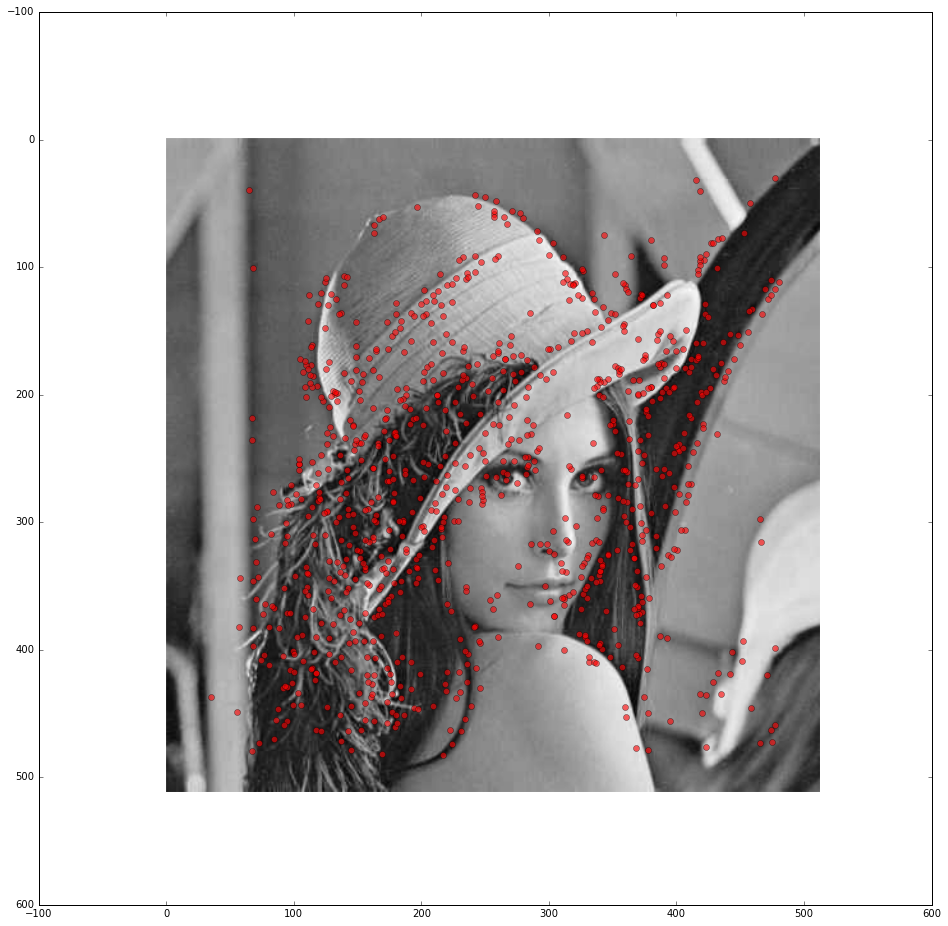

In [9]:
plt.figure(figsize=(16,24))
plt.imshow(img, cmap=plt.cm.gray, )

for row in ret:
    y = row[0]
    x = row[1]
    plt.plot(x,y,'ro', alpha=0.6)

plt.show()

<br/>
<br/>

###  Classification using SURF features and Visual Bag-of-Words approach

**Intuition** behind this approach is as follows: 

+ Images of the same class are likely to have some similar looking small areas. These small areas will not be exactly the same - there will be changes in position, scale, rotation, illumination, texture, etc - but they are likely to be _similar_. 

<br/> 

+ If we take each of these similar areas across all images, we can then describe each image as some combination of these similar areas, and train the classifier to relate particular combinations to particular classes. For example, Image A can be described as "5 areas like area1, 8 areas like area2, .....x number of areas like area-Y"...Image B as "3 areas like area1, 2 areas like area2, ...." and so on.

<br/> 

+ These similar areas become our _visual vocabulary_, and their combination and counts form the _Visual Bag of Words_ approach.

<br/> 
<br/> 

An **implementation** of this approach using SURF to find us these "similar areas" is done as follows:

- For every image, detect SURF keypoints and get their descriptors.

<br/>

- Collect all descriptors from all images and cluster them into a reasonable number of clusters using a clustering algorithm like K-Means.
  This is the equivalent of finding our "similar areas" across images. 
  
<br/>

- Now calculate the centroids of these clusters. 
  Each centroid is an abstract descriptor for a particular similar area across images, got by sort of averaging all the concrete descriptors of that area in every image.

<br/>

- For example one centroid may be the average of all helicopter rotor area descriptors (though in reality, they don't correspond to precise areas of an image. they are much more abstract, such as a corner with say 53 degree angle)

<br/>

- These centroid descriptors form our "bag of visual words". That is, every image can be expressed as a combination
  of these centroid descriptors with each centroid descriptor occurring with some frequency (possibly zero too) in that image.

<br/>

- Now that we know all the centroids of descriptors, we go through every image, take its descriptors,
  find out centroids to which each descriptor belongs, and count the number of descriptors belonging to each centroid.
  So if there are k centroids, we get k counts, each of which is a feature. 
  Do this for every image.  
  
<br/>

- If there are N images, we will now have an N x k feature set, where each value is a count of number of descriptors in each cluster.

<br/> 

- These cluster membership counts are our "bag of words", and are used as features for the classification algorithm.

In [13]:
from mahotas.features import surf

from glob import glob

# First element is the class label, second element is the subdirectory of image files
image_classes = [('animal', 'Anims'),
                 ('car', 'Cars'),
                 ('transport', 'Trans'),
                 ('other', 'Distras')]

img_count = 1

# List of descriptor set for each image.
surf_descriptors_of_images = []

labels = []
for idx_cl, cl in enumerate(image_classes):
    
    # Since we want to save and load labels array to HDF5, we'll store labels as numeric indexes
    # instead of strings. If storing as strings,they should be encoded as 'utf8' because
    # HDF5 can't store unicode arrays.
    label = idx_cl
    
    files = glob('BuildingMachineLearningSystemsWithPython/AnimTransDistr/{}/*'.format(cl[1]))
    for idx, f in enumerate(files):
        #if idx >= 10:
        #    break
            
        print('{} '.format(img_count), end='')
        
        labels.append(label)
        
        gray_img = mh.imread(f, as_grey=True)
        
        img_surf_descriptors = surf.surf(gray_img, descriptor_only = True)
        
        surf_descriptors_of_images.append(img_surf_descriptors)
        
        img_count += 1
        
print('\nImage Loading Complete')
print(len(surf_descriptors_of_images))

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

In [14]:
labels = np.array(labels, dtype=np.uint8)

In [3]:
# Functions to save and load image descriptors from HDF5 file.
# Both saving and loading are quite fast, but size of 2.5 million descriptors results in a 1.3 GB file.
#
# Since surf_descriptors_of_images is a python list (consisting of np.arrays)
# HDF5 can't save it directly. Instead, we have to iterate through it and save just the np.arrays.
# When loading, we recreate the python list by reading the np.arrays one by one.
#
# Update: Instead of HDF5, using sklearn.externals.joblib because it can persist any python objects
# and is optimized for numpy arrays.
#

from sklearn.externals import joblib

def save_surf_descriptors(surf_descriptors_of_images, labels):
    joblib.dump(surf_descriptors_of_images, 'animtrans-surf-descriptors.joblib', compress=3)
    joblib.dump(labels, 'animtrans-labels.joblib', compress=3)
            
            
def load_surf_descriptors():
    temp_descriptors_of_images = joblib.load('animtrans-surf-descriptors.joblib')
    temp_labels = joblib.load('animtrans-labels.joblib')
    return temp_descriptors_of_images, temp_labels

In [4]:
# Uncomment and run for saving. Warning: it overwrites existing file.
# save_surf_descriptors(surf_descriptors_of_images, labels)

In [5]:
%%time
# Uncomment and run for loading after a restart. Warning: it replaces surf_descriptors_of_images array.
surf_descriptors_of_images, labels = load_surf_descriptors()

CPU times: user 14.1 s, sys: 4.59 s, total: 18.7 s
Wall time: 25.6 s


In [6]:
# This combines all descriptors of all images into a single array, for clustering purposes.
all_surf_descriptors = np.concatenate(surf_descriptors_of_images)
all_surf_descriptors.shape

(2487358, 64)

So, there are around 2.5 million SURF descriptors across 3979 images, an average of around 625 descriptors per image.

### Selection of clustering algorithm for very high number of samples


We need to cluster around 2.5 million descriptors. 

Since the dataset has a variety of objects, orientations, textures and backgrounds even within a single class, it's probably a good idea for the visual vocabulary to be rich, which means the number of clusters should be high.

The idea here is to measure classification accuracy with different number of clusters -  from 256 to 1024 in steps of 256 - and maybe beyond 1024 if accuracy is observed to improve with higher clusters.

It turns out that `KMeans` is rather slow to converge for so many samples, even with a modest 16 clusters. Fortunately, sklearn's [clustering user guide](http://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods) does a good job of describing which algorithms to select.

Our options according to the user guide are:

+ KMeans (for baseline)
+ MiniBatchKMeans
+ DBSCAN (However, the user guide mentions in [DBSCAN section](http://scikit-learn.org/stable/modules/clustering.html#dbscan) that it's not memory efficient for large samples and may require some precomputation)
+ Ward hierarchical clustering
+ Agglomerative clustering
+ Birch (The user guide mentions in the [Birch section](http://scikit-learn.org/stable/modules/clustering.html#birch) that Birch is not suitable for features > 20 and MiniBatchKMeans should be preferred. Since we have 64-size descriptors, probably Birch is not a good model for this use case)

First, we'll try KMeans, MiniBatchKMeans and DBScan on a subset of the descriptors to get an idea of how much time each takes. 

**KMeans:**

In [9]:
%%time

from sklearn.cluster import KMeans

km = KMeans(n_clusters = 16, n_jobs = -1)
    
# After fitting, km object contains information about centroids of clusters.
km.fit(all_surf_descriptors[:100000])

CPU times: user 1.99 s, sys: 476 ms, total: 2.47 s
Wall time: 2min 57s


**Mini Batch KMeans:**

In [11]:
%%time

# Try with 100,000 samples into 16 clusters
from sklearn.cluster import MiniBatchKMeans

mbkm = MiniBatchKMeans(n_clusters = 16)
    
# After fitting, km object contains information about centroids of clusters.
mbkm.fit(all_surf_descriptors[:100000])

CPU times: user 3.79 s, sys: 204 ms, total: 3.99 s
Wall time: 2.16 s


In [12]:
%%time

# Try with 1 million samples into 256 clusters
from sklearn.cluster import MiniBatchKMeans

mbkm = MiniBatchKMeans(n_clusters = 256)
    
# After fitting, km object contains information about centroids of clusters.
mbkm.fit(all_surf_descriptors[:1000000])

CPU times: user 5min 17s, sys: 19.3 s, total: 5min 37s
Wall time: 3min 30s


**DBScan:**

In [14]:
%%time

# Try with 1 million samples into 256 clusters
from sklearn.cluster import DBSCAN

dbscan = DBSCAN()
    
# After fitting, km object contains information about centroids of clusters.
dbscan.fit(all_surf_descriptors[:10000])

CPU times: user 41.8 s, sys: 238 ms, total: 42.1 s
Wall time: 44.9 s


**Clustering algorithm conclusion:** 
+ Kmeans: 
  - 100,000 samples in 16 clusters took ~3 minutes
  
+ MiniBatchKmeans: 

  - 100,000 samples in 16 clusters took just 3 *seconds*
  - 1 million samples in 256 clusters took an acceptable 3.5 minutes
  
+ DBSCAN:
  - Just 10,000 samples took ~45 seconds,
  
So we'll use MiniBatchKMeans to reduce time taken.  

### Back to image classification

In [10]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.externals import joblib

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

def get_visual_bag_of_words(num_clusters, all_surf_descriptors, surf_descriptors_of_images):

    # An image's descriptor counts in clusters form our "bag of words". 
    # This list holds these cluster counts for every image in dataset.

    surf_bow_features = []

    print("Clustering with k=", num_clusters)
    
    # n_jobs = -1 means use all CPUs. KMeans accepts n_jobs, but MiniBatchKMeans does not.
    # Avoid verbose=1 for this, it generates massive amounts of output.
    # Should 'max_iter' be proportional to number of clusters or number of samples? By default it's just 300 which
    # doesn't seem right when there are millions of samples.
    km = MiniBatchKMeans(n_clusters = num_clusters)
    
    # After fitting, km object contains information about centroids of clusters.
    km.fit(all_surf_descriptors)

    joblib.dump(km, 
                'animtrans-kmeans-{}-clusters.joblib'.format(num_clusters),
               compress=3)

    for idx, descriptors_of_img in enumerate(surf_descriptors_of_images):
        print("{} ".format(idx), end='')
        
        # km.predict() can receive a list of vectors and return the closest cluster for each.
        # So if img has D descriptors, this will return D cluster assignments, one per descriptor.
        clusters = km.predict(descriptors_of_img)
        cluster_counts = np.bincount(clusters, minlength = num_clusters)
        surf_bow_features.append(cluster_counts)
        
    surf_bow_features = np.array(surf_bow_features, dtype=np.float)
    
    print("\n\nSURF features:", surf_bow_features.shape)

    joblib.dump(surf_bow_features, 
               'animtrans-bow-features-{}-clusters.joblib'.format(num_clusters),
               compress=3)
    
    return surf_bow_features



def predict_reg_LR(surf_bow_features, labels):
    print("\nPredicting with regularized logistic regression")
    
    C_range = 10.0 ** np.arange(-4,3)

    reg_logistic_regr = GridSearchCV(LogisticRegression(), param_grid={'C':C_range})

    clf = Pipeline([('scaler', StandardScaler()),
                    ('classifier', reg_logistic_regr)])
    
    kfold_cv = KFold(len(surf_bow_features), 5, shuffle=True)

    score_surf = cross_val_score(clf, surf_bow_features, labels, cv = kfold_cv, verbose=1)
    print('Accuracy (5 fold crossval) with Logistic Regression [SURF features]: {:.1%}'.format(score_surf.mean()))
    
    
    
def predict_SVM(surf_bow_features, labels):
    print("\nPredicting with SVM")
    
    svm = SVC()

    # Scaling of features is important for SVM to avoid bias by large valued features.
    clf = Pipeline([('scaler', StandardScaler()),
                    ('classifier', svm)])
    
    kfold_cv = KFold(len(surf_bow_features), 5, shuffle=True)

    score_surf = cross_val_score(clf, surf_bow_features, labels, cv = kfold_cv, verbose=1)
    print('Accuracy (5 fold crossval) with SVM [SURF features]: {:.1%}'.format(score_surf.mean()))
    
    
    
def predict_LinearSVM(surf_bow_features, labels):
    print("\nPredicting with LinearSVM")
    
    lin_svm = LinearSVC()

    # Scaling of features is important for SVM to avoid bias by large valued features.
    clf = Pipeline([('scaler', StandardScaler()),
                    ('classifier', lin_svm)])
    
    kfold_cv = KFold(len(surf_bow_features), 5, shuffle=True)

    score_surf = cross_val_score(clf, surf_bow_features, labels, cv = kfold_cv, verbose=1)
    print('Accuracy (5 fold crossval) with Linear SVM [SURF features]: {:.1%}'.format(score_surf.mean()))
    
    
    
def predict_random_forest(surf_bow_features, labels):
    print("\nPredicting with Random Forest")
    
    rf = RandomForestClassifier()

    # Random forests don't require feature scaling.
    
    kfold_cv = KFold(len(surf_bow_features), 5, shuffle=True)

    score_surf = cross_val_score(rf, surf_bow_features, labels, cv = kfold_cv, verbose=1)
    print('Accuracy (5 fold crossval) with Random Forest [SURF features]: {:.1%}'.format(score_surf.mean()))
    
    
    

In [35]:
%%time

bow_16_features = get_visual_bag_of_words(16, all_surf_descriptors, surf_descriptors_of_images)


Clustering with k= 16
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 

In [37]:
%%time

bow_256_features = get_visual_bag_of_words(256, all_surf_descriptors, surf_descriptors_of_images)


Clustering with k= 256
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271

In [11]:
%%time

bow_1024_features = get_visual_bag_of_words(1024, all_surf_descriptors, surf_descriptors_of_images)


Clustering with k= 1024


/home/karthik/work/anaconda3/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:1300: RuntimeWarning: init_size=300 should be larger than k=1024. Setting it to 3*k
  init_size=init_size)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [ ]:
# Load 16-cluster features from file instead of calculating them
bow_16_features = joblib.load('animtrans-bow-features-16-clusters.joblib')

In [ ]:
# Load 256-cluster features from file instead of calculating them
bow_256_features = joblib.load('animtrans-bow-features-256-clusters.joblib')

In [ ]:
# Load 256-cluster features from file instead of calculating them
bow_1024_features = joblib.load('animtrans-bow-features-1024-clusters.joblib')

In [ ]:
# Load labels from file instead of calculating them
labels = joblib.load('animtrans-labels.joblib')

<br/>
**Evaluation of Classification Algorithms:**

In [40]:
%%time

predict_reg_LR(bow_16_features, labels)


Predicting with regularized logistic regression
Accuracy (5 fold crossval) with Logistic Regression [SURF features]: 55.5%
CPU times: user 17.6 s, sys: 948 ms, total: 18.5 s
Wall time: 9.56 s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.5s finished


In [41]:
%%time

predict_reg_LR(bow_256_features, labels)


Predicting with regularized logistic regression
Accuracy (5 fold crossval) with Logistic Regression [SURF features]: 63.0%
CPU times: user 4min 17s, sys: 3.37 s, total: 4min 20s
Wall time: 3min 57s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.0min finished


In [13]:
%%time

predict_reg_LR(bow_1024_features, labels)


Predicting with regularized logistic regression
Accuracy (5 fold crossval) with Logistic Regression [SURF features]: 63.8%
CPU times: user 27min 41s, sys: 4.83 s, total: 27min 45s
Wall time: 27min 29s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 27.5min finished


In [45]:
%%time

predict_SVM(bow_16_features, labels)


Predicting with SVM
Accuracy (5 fold crossval) with SVM [SURF features]: 60.1%
CPU times: user 8.48 s, sys: 11.4 ms, total: 8.49 s
Wall time: 8.66 s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.7s finished


In [46]:
%%time

predict_SVM(bow_256_features, labels)


Predicting with SVM
Accuracy (5 fold crossval) with SVM [SURF features]: 67.0%
CPU times: user 1min 5s, sys: 268 ms, total: 1min 6s
Wall time: 1min 14s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished


In [14]:
%%time

predict_SVM(bow_1024_features, labels)


Predicting with SVM
Accuracy (5 fold crossval) with SVM [SURF features]: 65.2%
CPU times: user 4min 35s, sys: 580 ms, total: 4min 35s
Wall time: 4min 36s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.6min finished


In [48]:
%%time

predict_LinearSVM(bow_16_features, labels)


Predicting with LinearSVM
Accuracy (5 fold crossval) with Linear SVM [SURF features]: 55.7%
CPU times: user 28.2 s, sys: 223 ms, total: 28.4 s
Wall time: 27.5 s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.5s finished


In [49]:
%%time

predict_LinearSVM(bow_256_features, labels)


Predicting with LinearSVM
Accuracy (5 fold crossval) with Linear SVM [SURF features]: 60.7%
CPU times: user 2min 46s, sys: 340 ms, total: 2min 47s
Wall time: 2min 46s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min finished


In [15]:
%%time

predict_LinearSVM(bow_1024_features, labels)


Predicting with LinearSVM
Accuracy (5 fold crossval) with Linear SVM [SURF features]: 51.0%
CPU times: user 4min 32s, sys: 489 ms, total: 4min 33s
Wall time: 4min 32s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.5min finished


In [52]:
%%time

predict_random_forest(bow_16_features, labels)


Predicting with Random Forest
Accuracy (5 fold crossval) with Random Forest [SURF features]: 56.3%
CPU times: user 966 ms, sys: 3.92 ms, total: 970 ms
Wall time: 1.39 s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished


In [53]:
%%time

predict_random_forest(bow_256_features, labels)


Predicting with Random Forest
Accuracy (5 fold crossval) with Random Forest [SURF features]: 53.9%
CPU times: user 2.08 s, sys: 0 ns, total: 2.08 s
Wall time: 2.14 s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished


In [16]:
%%time

predict_random_forest(bow_1024_features, labels)


Predicting with Random Forest
Accuracy (5 fold crossval) with Random Forest [SURF features]: 51.0%
CPU times: user 3.2 s, sys: 39.2 ms, total: 3.24 s
Wall time: 3.4 s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.4s finished


**Results:**

Clusters | Algorithm | Accuracy | Prediction Time taken
-|-|-
16 | Reg Log Regression | 56.8% | 10s
16 | SVM | 60.1% | 9s
16 | Linear SVM | 55.7% | 27.5s
16 | Random Forest | 56.3% | 1.4s
256 | Reg Log Regression | 63.3% | 4 minutes
256 | SVM | 67% | 1m 14s
256 | Linear SVM | 60.7% | 2m 46s
256 | Random Forest | 53.9% | 2.1s
1024 | Reg Log Regression | 63.8% | 27.5 minutes
1024 | SVM | 65.2% | 4.5 minutes
1024 | Linear SVM | 51% | 4.5m
1024 | Random Forest | 51% | 3.4s

Clustering times:

Clusters | Time taken
-|-
16 | 1m 5s
256 | 12 minutes
1024 | 14 minutes

+ I find it really surprising that a visual vocabulary of just 16 yielded 57% accuracy but a squaring of the vocabulary to 256 and even 1024 yielded just 6% more accuracy.

+ Increasing to 1024 features either kept accuracy roughly the same or even reduced it drastically.

+ Random forest is very fast, but more features seem to reduce accuracy drastically.


**Conclusions:**

It does look like there is a sweet spot for the ideal count of clustered SURF (or other interest point) descriptors. 

Too few means the vocabulary is not expressive enough to discriminate between classes.

But too many means classifiers get confused between classes and reduce accuracy, probably because descriptors related to things other than the primary object are present in other classes too (example: trees, clouds, etc) and influence the classification.

<br/>
<br/>

<hr style="border-color:blue"/>

<br/>
<br/>



## III. Unsupervised learning - Find Similar images

Finding similar images is a common task in computer vision. Given an image, we want to find the image nearest to it in feature space. 

One of the pre-processing steps will be to crop the edges of all pictures before calculating distances, because these amateur photo compositions will have many differences between each other around the edges which adds noise to the feature distances. In supervised classification, this is not a problem because the classifier learns to discard this noise, but in unsupervised learning, it has to be done explicitly.

Once the features of all images are extracted, we use `scipy.spatial.distance.pdist()` to calculate euclidean distances between every pair of images. If there are m images and n features, this returns a $ m(m-1) \over 2 $ -sized vector of distances. That's because 

+ for 1st image, we need to calculate distances to all other m-1 images
+ for 2nd image, we need to calculate distances only to all images except to 1st image, which means to m-2 images.
+ ....

This means number of distances to calculate is $ (m-1) + (m-2) + ..... + 2 + 1 = {m(m-1) \over 2} $

<br/>

After pairwise distances are calculated, we can convert it to a square $ m \  x \  m $-sized matrix using `scipy.spatial.distance.squareform()` to look up the distance between any two images easily.

In [25]:
from glob import glob
import os

images = glob('BuildingMachineLearningSystemsWithPython/SimpleImageDataset/*')

all_features = None

for idx, i in enumerate(images):
    #if idx >= 3:
    #    break
        
    print('Image {0}:{1}'.format(idx, i))
    
    temp_rgb_img = mh.imread(i, as_grey=False)
    
    # Crop the edges out of the image because edges typically add a lot of noise to the
    # distance metrics.
    cropped_rgb_img = temp_rgb_img[200:-200, 200:-200, :]
    
    cropped_grey_img = mh.colors.rgb2grey(cropped_rgb_img).astype(np.uint8)
    
    har_features = mh.features.haralick(cropped_grey_img).ravel()
    chist_features = chist(cropped_rgb_img)
    
    img_features = np.hstack((har_features, chist_features))
    
    if all_features is None:
        all_features = img_features
    else:
        all_features = np.vstack((all_features, img_features))
        
pairwise_distances = distance.pdist(all_features)
print("\n\nPairwise Distances:", pairwise_distances.shape)
print(pairwise_distances)

dist_matrix = distance.squareform(pairwise_distances)
print("\n\nDistance matrix:", dist_matrix.shape)
print(dist_matrix)

Image 0:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/text07.jpg
Image 1:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/text01.jpg
Image 2:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/building05.jpg
Image 3:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/building22.jpg
Image 4:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/scene12.jpg
Image 5:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/scene13.jpg
Image 6:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/scene18.jpg
Image 7:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/scene07.jpg
Image 8:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/text11.jpg
Image 9:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/text06.jpg
Image 10:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/scene04.jpg
Image 11:BuildingMachineLearningSystemsWithPython/SimpleImageDataset/building00.jpg
Image 12:BuildingMachineLearningS

We now randomly select 10 images and find the nearest image to each. For each one, we know the distances to all other images, and we just have to sort them and select the least.

Finding nearest image for BuildingMachineLearningSystemsWithPython/SimpleImageDataset/scene12.jpg
Finding nearest image for BuildingMachineLearningSystemsWithPython/SimpleImageDataset/building29.jpg
Finding nearest image for BuildingMachineLearningSystemsWithPython/SimpleImageDataset/scene23.jpg
Finding nearest image for BuildingMachineLearningSystemsWithPython/SimpleImageDataset/building20.jpg
Finding nearest image for BuildingMachineLearningSystemsWithPython/SimpleImageDataset/text15.jpg
Finding nearest image for BuildingMachineLearningSystemsWithPython/SimpleImageDataset/building19.jpg
Finding nearest image for BuildingMachineLearningSystemsWithPython/SimpleImageDataset/scene26.jpg
Finding nearest image for BuildingMachineLearningSystemsWithPython/SimpleImageDataset/text25.jpg
Finding nearest image for BuildingMachineLearningSystemsWithPython/SimpleImageDataset/scene05.jpg
Finding nearest image for BuildingMachineLearningSystemsWithPython/SimpleImageDataset/scene11.jpg


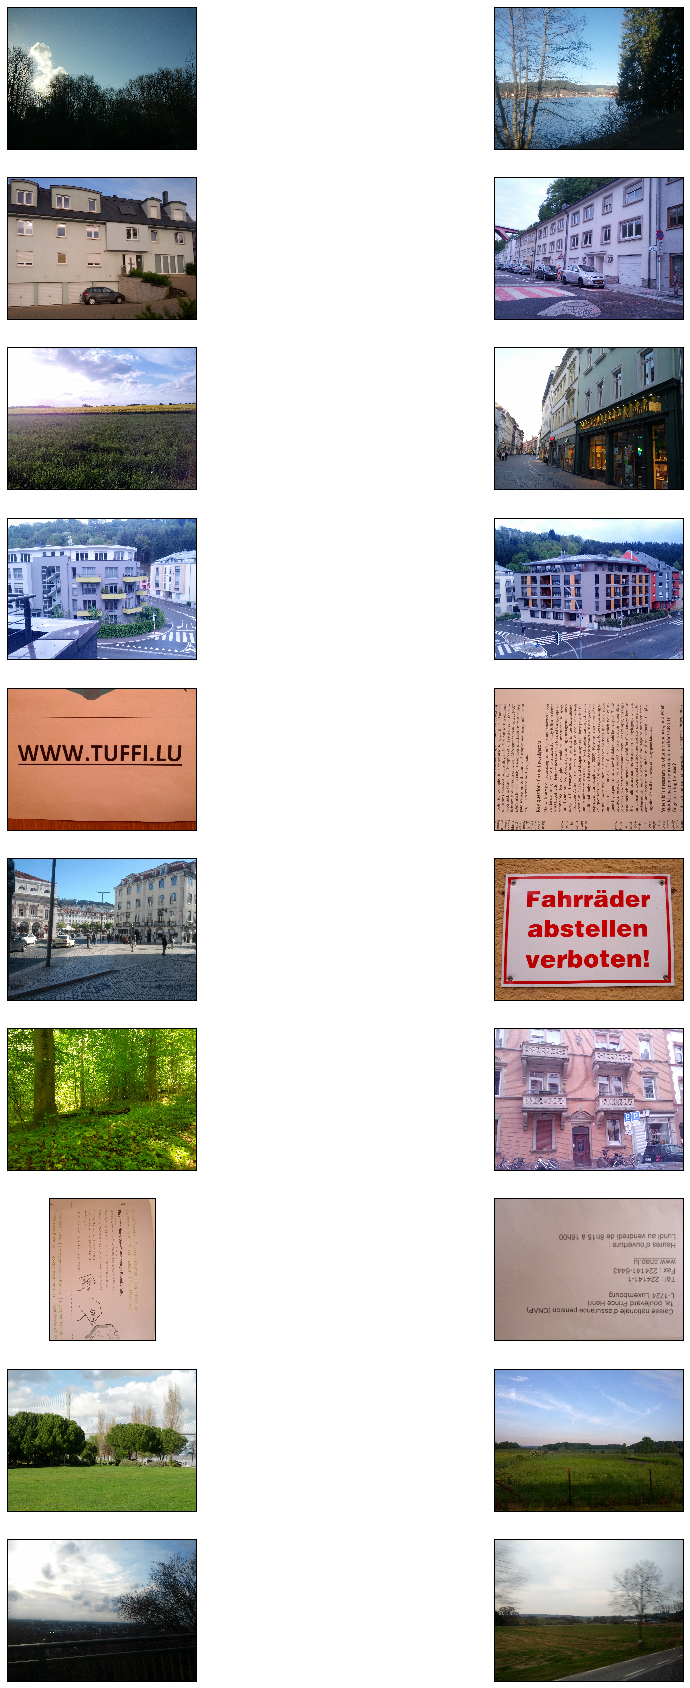

In [48]:
# We'll plot it as 10 rows of 2 columns - 1st column is randomly selected image, 2nd column is its most similar one.
plt_index = 1
plt.figure(figsize=(16,30))

for idx in np.random.randint(0,90,10) :
    print('Finding nearest image for ' + images[idx])
    distances_for_sel_img = dist_matrix[idx]
    
    # This gives us indexes of elements such that elements would be in sorted order.
    sorted_distance_order = np.argsort(distances_for_sel_img)
    
    # First index in sorted order is the distance to itself, zero. So we ignore it and use the second index.
    nearest_img_idx = sorted_distance_order[1]

    sel_img = mh.imread(images[idx], as_grey=False)
    
    nearest_img = mh.imread(images[nearest_img_idx], as_grey=False)
    
    plt.subplot(10, 2, plt_index)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.imshow(sel_img)
    
    plt.subplot(10, 2, plt_index + 1)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.imshow(nearest_img)
    
    plt_index += 2
    
plt.show()